# correction du modèle stratifié Zhan JING

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("../data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("../data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("../configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a
# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + 273.15
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + 273.15
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + 273.15
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + 273.15
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + 273.15

In [5]:
# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [6]:
col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, .4],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

In [7]:
temps_en_jours = np.array([i for i in range(len(col._times))]) / (4*24)

## 2. Modèle direct

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Colonne homogène

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

NB: Dans ``core.py`` nous avons intégré le cas homogène dans la fonction du cas stratifié, et nous avons éliminé les fonctions ``compute_H`` et ``compute_T`` dans  ``utils.py``

In [8]:
params = Param(
    moinslog10K = 4+7,
    n = .1,
    lambda_s = 2,
    rhos_cs = 4e6
)

params_tuple = (4+7, .1, 2, 4e6)

assert params == params_tuple

NB: Ici nous avons remplacé dans la variable ``moinslog10K`` par $ke\in [11, 16]$ tel que:

$\frac{\rho_w g 10.0^{ke}}{\mu} = K$

même si ils sont encore noté ``moinslog10K``

Puis on appelle le modèle direct :

In [9]:
col.compute_solve_transi(params, nb_cells=100)

--- Compute Solve Transi ---
One layer : moinslog10K = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0
Done.


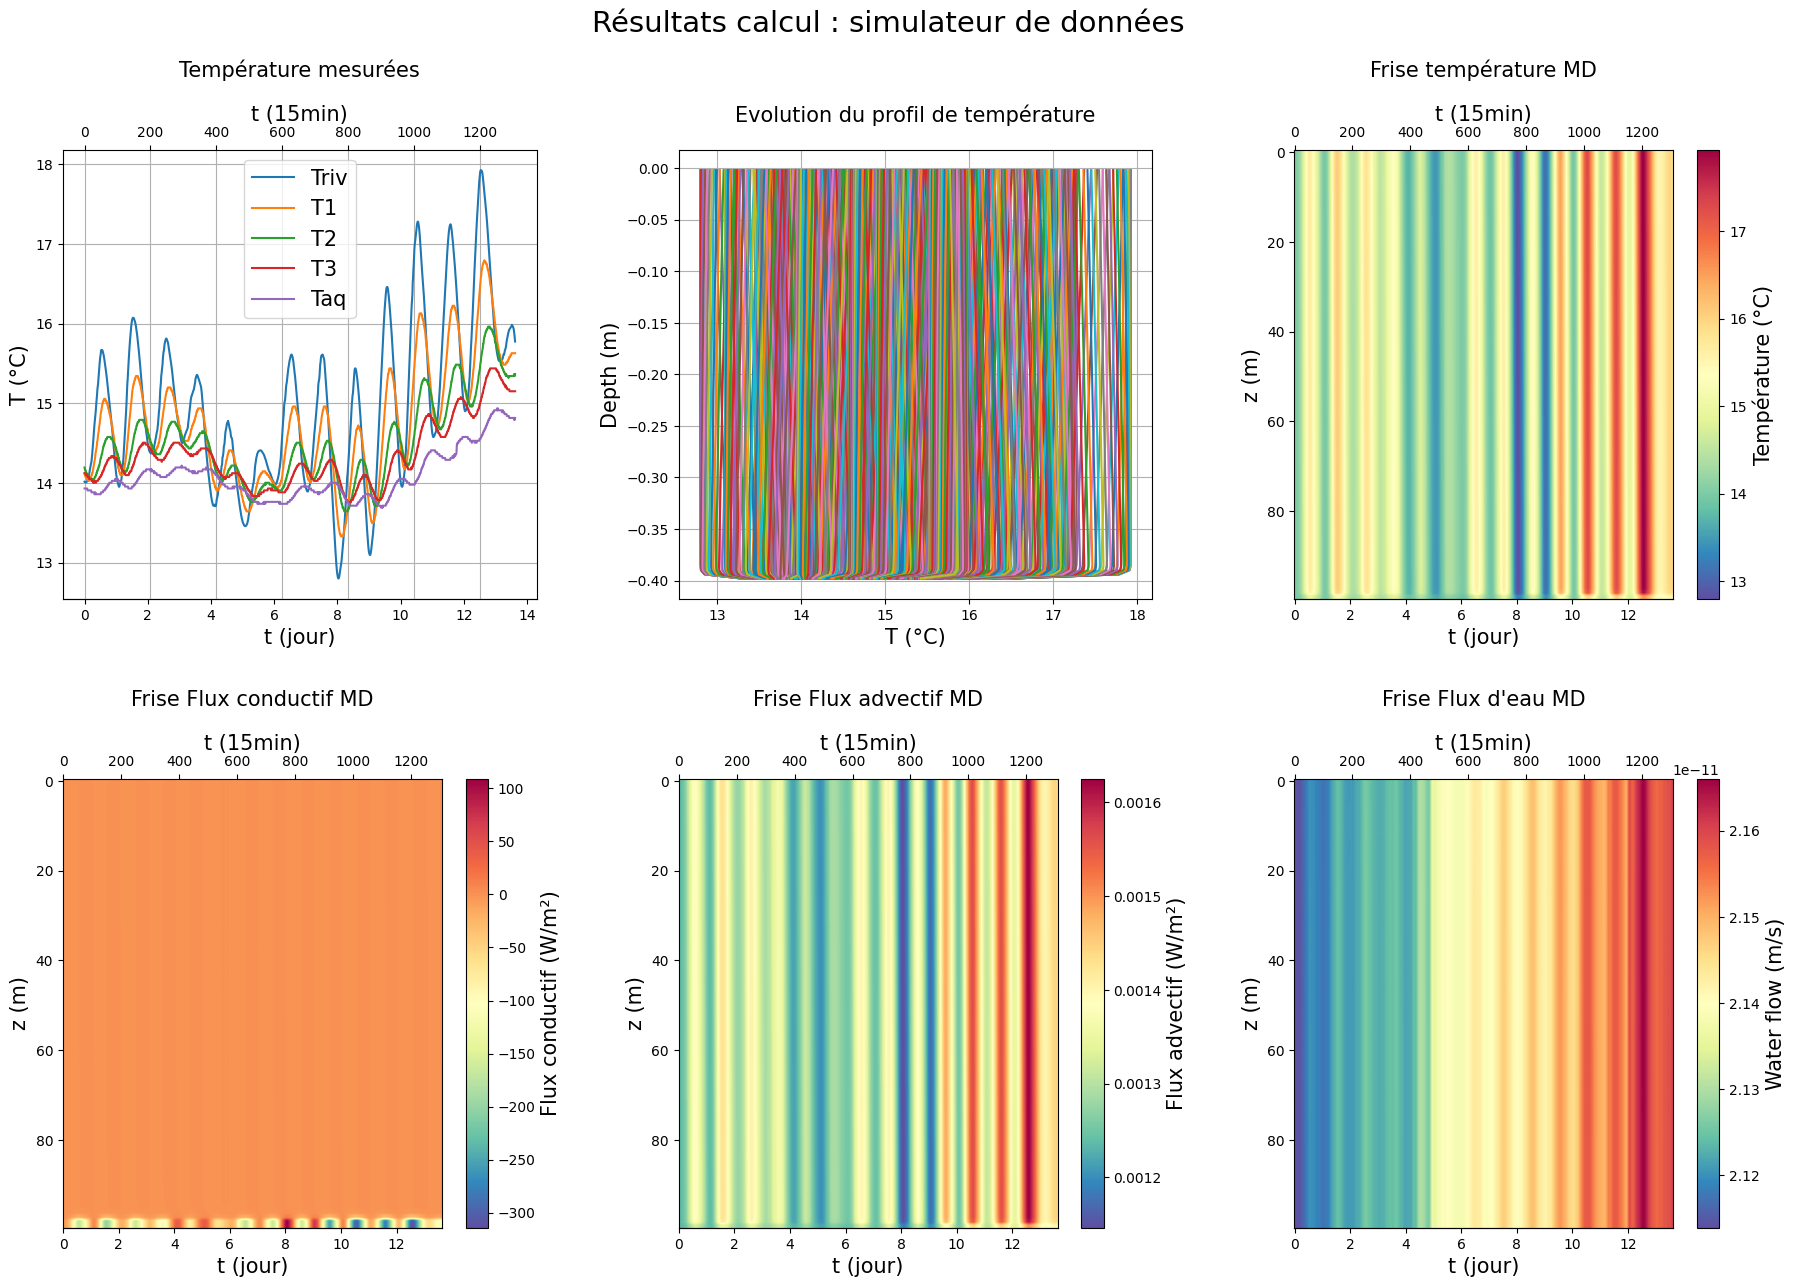

In [10]:
col.plot_CALC_results(nt=len(col._times))

### 2.2. Colonne stratifiée

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [11]:
layers_list = layersListCreator([("Couche 1", 0.20, 5+7, 0.1, 2, 4e6), ("Couche 2", 0.40, 7+7, 0.1, 2, 4e6)])


Puis on appelle le modèle direct :

charge hydraulique sur chaque interface [0.84556517 0.83719324 0.        ]


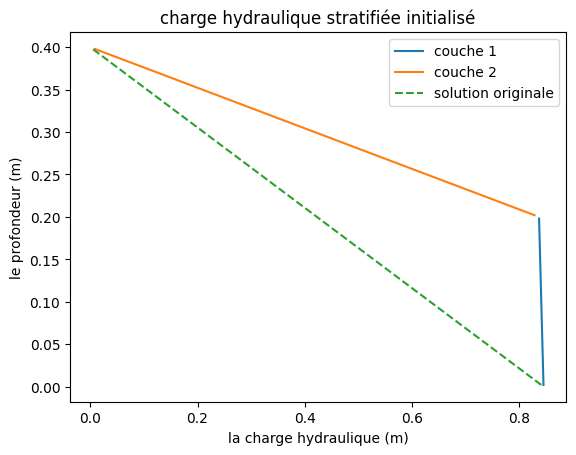

--- Compute Solve Transi ---
Couche 1 : ends at 0.2 m. Parametres(moinslog10K=12, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Couche 2 : ends at 0.4 m. Parametres(moinslog10K=14, n=0.1, lambda_s=2, rhos_cs=4000000.0)
Hinter [0.84556517 0.83719324 0.        ]
conditions aux limites
H_riv [0.84556517 0.84559872 0.84563867 ... 0.86422199 0.86423169 0.86416241]
H_aq [0. 0. 0. ... 0. 0. 0.]
échantillons du profondeur: ...  0.198 0.202  ...
le profondeur d'interface:  0.2
type cara asymetric


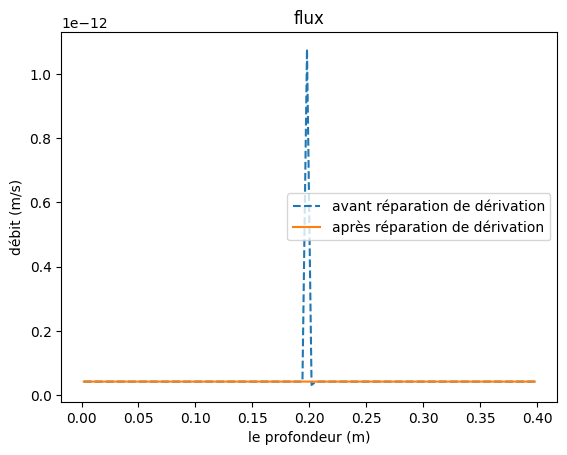

Done.


In [20]:
col.compute_solve_transi(layers_list, nb_cells=100)

NB1: Selon la loi de Kirchoff, nous devons nous assurer que l'écoulement est cohérent à l'interface de différentes couches de perméabilité. Comme indiqué ci-dessus, nous corrigeons la courbe de charge hydraulique de sorte que, pour des valeurs H_riv et H_aq fixes, la différence de charge dans chaque couche multipliée par la perméabilité de cette couche K soit constante. Ainsi, contrairement à la fonction linéaire dans le cas d'un seul milieu, la charge hydraulique multicouche est initialisée comme une fonction linéaire segmentée.

NB2: Dans la matrice du schéma numérique de l'équation de chaleur, les dérivées discrétisées du second ordre de la charge hydraulique à l'interface de jonction des différentes couches doivent tenir compte du fait que les paramètres de perméabilité sont différents de part et d'autre de l'interface, faute de quoi elles convergeront vers une solution erronée, et nous donnons ici la formulation modifiée :

$\frac{K_1}{Ss_1}\frac{\alpha}{\Delta x^2}H^{n+1}_{j - 1} - (\frac{K_2}{Ss_2} + \frac{K_1}{Ss_1})\frac{\alpha}{\Delta x^2}H^{n+1}_j + \frac{K_2}{Ss_2}\frac{\alpha}{\Delta x^2}H^{n+1}_{j + 1} - \frac{H^{n+1}_j}{\Delta t} = -\frac{K_1}{Ss_1}\frac{(1 - \alpha)}{\Delta x^2}H^{n}_{j - 1} + (\frac{K_2}{Ss_2} + \frac{K_1}{Ss_1})\frac{(1 - \alpha)}{\Delta x^2}H^{n}_j - \frac{K_2}{Ss_2}\frac{(1 - \alpha)}{\Delta x^2}H^{n}_{j + 1} - \frac{H^{n}_j}{\Delta t}$

NB3: Sur la base de cette matrice, nous devons étudier le cas où le paramètre $Ss$ est différent dans chaque couche, et donc séparer $\frac{K}{Ss}$ pour que $Ss$ devienne le paramètre de la charge hydraulique par rapport à la dérivée temporelle. Sinon si nous considérons seulement si $\frac{K}{Ss}$ varie avec la couche, nous obtiendrons toujours une solution erronée.

NB4: Sur la base de ce qui précède, nous obtenons la courbe correcte de la charge hydraulique et devons calculer sa dérivée $\nabla H$ pour les calculs ultérieurs de débit et de température, puisque la charge hydraulique actuelle est déjà segmentée et continue, nous devons calculer les dérivées gauche et droite pour les interfaces discontinues, dans la figure 2 ci-dessus, la ligne bleue en pointillés est la $\nabla H$ pré-corrigée et la ligne jaune en trait plein est la ligne corrigée.

### zhan: voyons que le charge hydraulique initialisé en suivant la loi de conservation de flux sur chaque d'interface est comme ci-dessus, maintenant nous étudions son évaluation avec le temps

### étudions la perméabilité sur l'interface

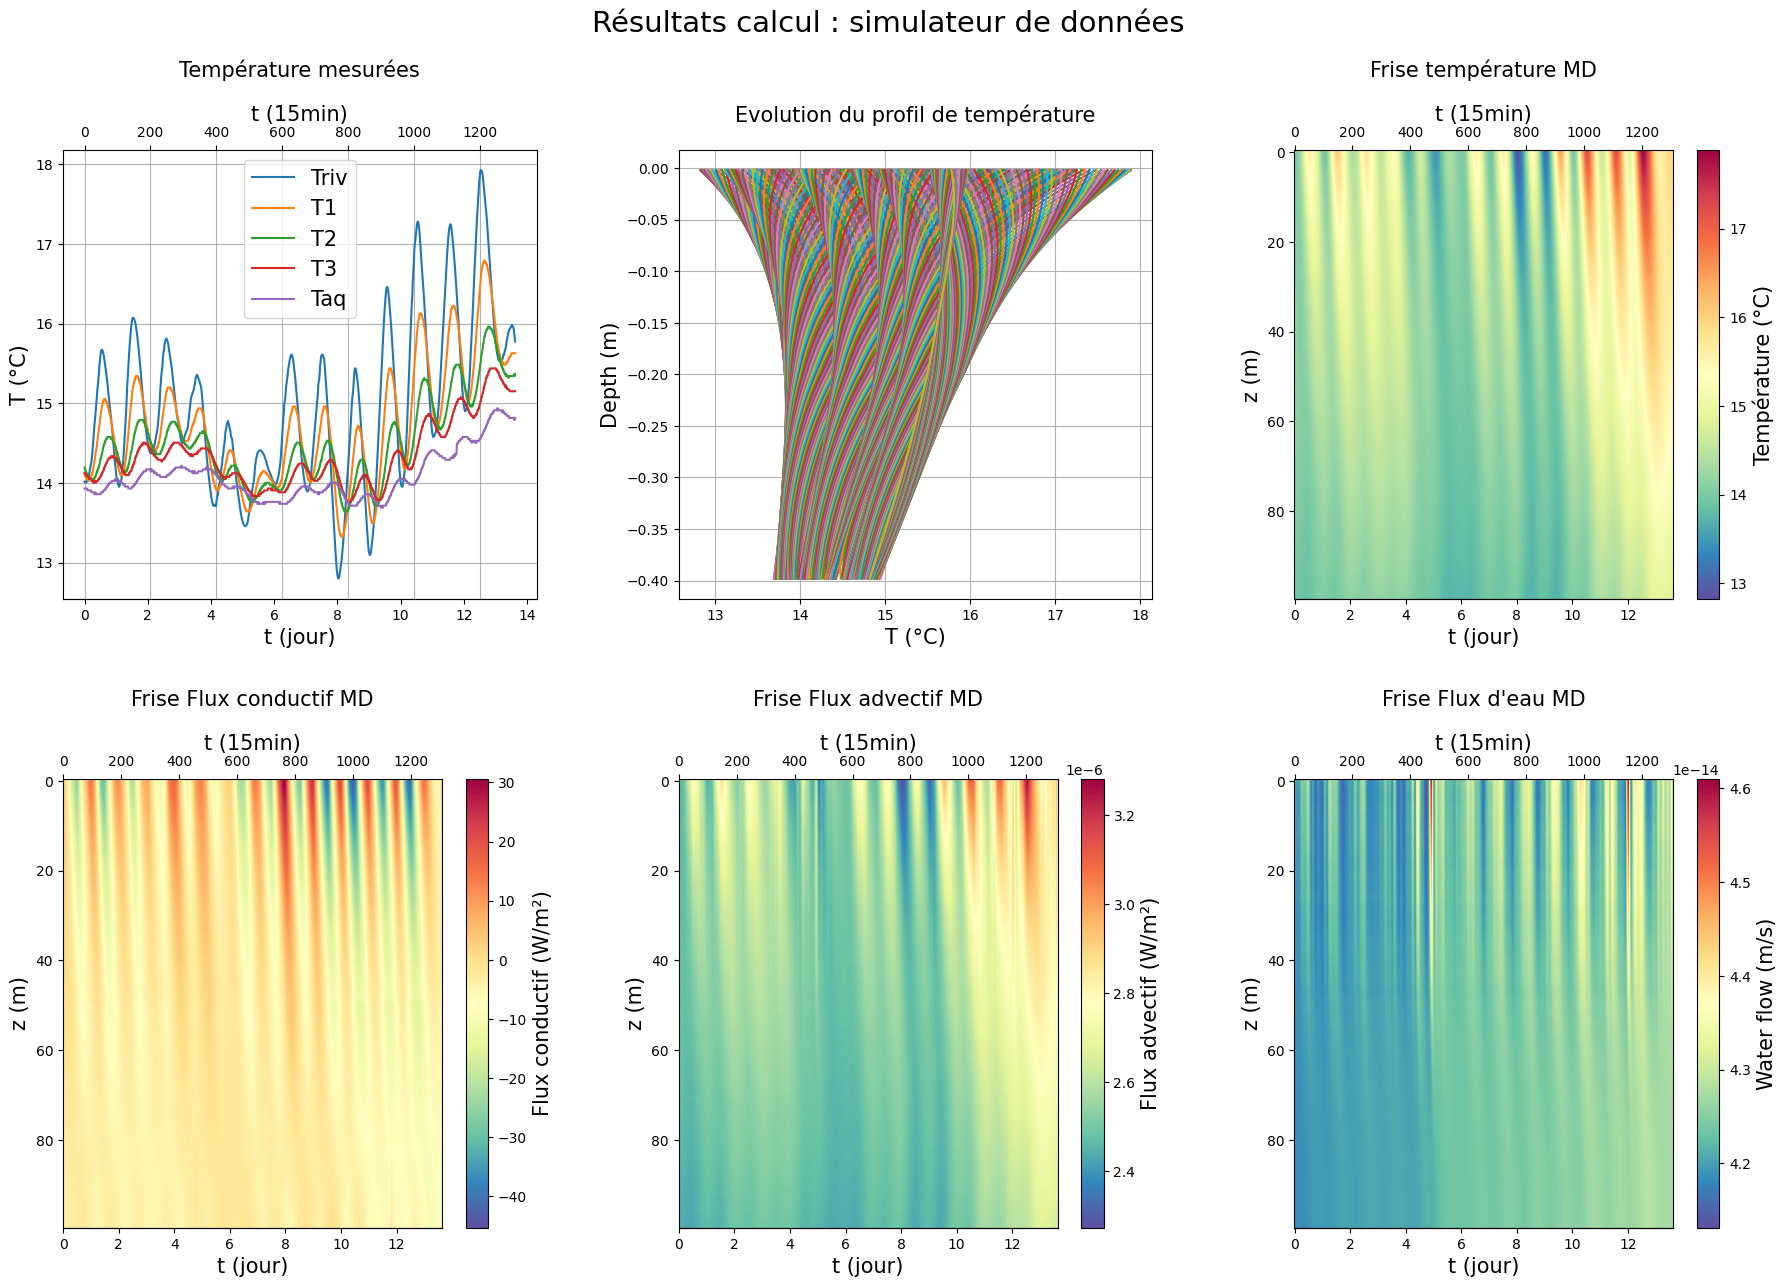

In [18]:
col.plot_CALC_results(nt=len(col._times))

NB5: La correction pour le schéma numérique matrice est divisée en deux cas, l'un dans lequel il existe un point d'échantillonnage spatial qui coïncide exactement avec l'interface (voir NB3), et dans le cas où le point d'échantillonnage spatial ne coïncide pas avec l'interface, les points d'échantillonnage qui contiennent les deux taux de perméabilité différents sont distribués de part et d'autre de l'interface et tous deux ne sont pas nécessairement équidistants de l'interface. Nous proposons ici deux approches : l'une consiste à considérer ces deux perméabilités comme une perméabilité équivalente $\frac{1}{K_{eq}} = \frac{x}{K_1}+\frac{1-x}{K_2}$ dans le micro-élément de $dz$, l'autre consiste à pondérer le paramètre matriciel à l'interface en fonction de la distance du point d'échantillonnage à l'interface $x :(1-x)$ et à le combiner avec la formule de $NB2$. Les paramètres matriciels avec une correction pondérée. Nous utilisons le premier cas dans le code d'intégration pyheatme, et nous décrivons les paramètres de la matrice d'interface correspondant au second cas en utilisant sympy

In [21]:
import sympy as sp


K1, K2, h1, h2 = sp.symbols('K1 K2 h1 h2', positive=True) # h1 et h2 sont repectivement les distances entre les point d'échantillon et l'interface
Um, Up = sp.symbols('Hm, Hp') # H moins et H plus sont les valeurs de la charge hydraulique d'échantillon correspondentes


A = sp.Matrix([[0, K1, -K2], [1, -h1, 0], [1, 0, h2]])


A_inv = A.inv()


A_inv
sp.Matrix([0, Um, Up])
A_inv * sp.Matrix([0, Um, Up])

Matrix([
[Hm*K1*h2/(K1*h2 + K2*h1) + Hp*K2*h1/(K1*h2 + K2*h1)],
[     -Hm*K2/(K1*h2 + K2*h1) + Hp*K2/(K1*h2 + K2*h1)],
[     -Hm*K1/(K1*h2 + K2*h1) + Hp*K1/(K1*h2 + K2*h1)]])

NB6: Selon $\frac{\partial \frac{\partial(Kh)}{\partial z}}{\partial z} = K\frac{\partial^2 h}{(\partial z)^2}+\frac{\partial K}{\partial z}\frac{\partial h}{\partial z}$, il y aura une direction d'optimisation en ajoutant le terme $div(K)$ si $K(z)$ deviendra une fonction continue, actuellement nous avons ajouté ce terme dans la fonction ``compute_HTK_stratified`` dans ``utils.py``, pour mieux modéliser la perméabilité influencé par les autres éléments spatiaux ce terme sera important, et les méthodes du traitement schéma numérique addressé au-dessus sont encore efficace en assurant la convergence du profil

l'élément fini de la formule suit le pseudo-code suivant avec $AH^{j+1} = BH^j+C$ et

$H^j, \forall j$ le vecteur temporel du columne de la charge hydraulique 

$C$ le vecteur des condition aux bornes

Comme mentioné ci-dessus, le code suivant n'est pas à exécuter, il nécessite le traitement aux interfaces

In [ ]:
    dK_list[0] = (K_list[1] - K_list[0]) / dz
    dK_list[-1] = (K_list[-1] - K_list[-2]) / dz
    for idx in range(1, len(dK_list) - 1):
        dK_list[idx] = (dK_list[idx+1] - dK_list[idx-1]) / 2 / dz
    lower_diagonal_B = K_list[1:]*alpha/dz**2  + dK_list[1:] * alpha / (2*dz)
    lower_diagonal_B[-1] = 4*K_list[n_cell - 1]*alpha/(3*dz**2)  + 4*dK_list[n_cell - 1] * alpha / (3*2*dz)

    diagonal_B =  Ss_list * 1/dt - 2*K_list*alpha/dz**2
    diagonal_B[0] =  Ss_list[0] * 1/dt - 4*K_list[0]*alpha/dz**2
    diagonal_B[-1] =  Ss_list[n_cell - 1] * 1/dt - 4*K_list[n_cell - 1]*alpha/dz**2

    upper_diagonal_B = K_list[:-1]*alpha/dz**2  - dK_list[:-1]*alpha / (2*dz)
    upper_diagonal_B[0] = 4*K_list[0]*alpha/(3*dz**2)  - 4*dK_list[0]*alpha / (3*2*dz)

    lower_diagonal_A = -K_list[1:]*(1-alpha)/dz**2  - dK_list[1:] * (1-alpha) / (2*dz)
    lower_diagonal_A[-1] = -4*K_list[n_cell - 1]*(1-alpha)/(3*dz**2)  - 4 * dK_list[n_cell - 1] * (1-alpha) / (3*2*dz)

    diagonal_A =  Ss_list * 1/dt + 2*K_list*(1-alpha)/dz**2
    diagonal_A[0] =  Ss_list[0] * 1/dt + 4*K_list[0]*(1-alpha)/dz**2
    diagonal_A[-1] =  Ss_list[n_cell - 1] * 1/dt + 4*K_list[n_cell - 1]*(1-alpha)/dz**2

    upper_diagonal_A =  -K_list[:-1]*(1-alpha)/dz**2  + dK_list[:-1]*(1-alpha)/(2*dz)
    upper_diagonal_A[0] =  -4*K_list[0]*(1-alpha)/(3*dz**2)  + 4 * dK_list[0]*(1-alpha)/(3*2*dz)

    for j in range(n_times - 1):
 
        c = zeros(n_cell, float32)
        c[0] = (8*K_list[0] / (3*dz**2)) * ((1-alpha)*H_riv[j+1] + alpha*H_riv[j]) # + 8/3 * (dK_list[0] * (-1) / 2 / dz) * ((1-alpha)*H_riv[j+1] + alpha*H_riv[j])
        c[-1] = (8*K_list[n_cell - 1] / (3*dz**2)) * ((1-alpha)*H_aq[j+1] + alpha*H_aq[j]) # + 8/3 * (dK_list[n_cell - 1] * (-1) / 2 / dz) * ((1-alpha)*H_aq[j+1] + alpha*H_aq[j])

        B_fois_H_plus_c = tri_product(
            lower_diagonal_B, diagonal_B, upper_diagonal_B, H_res[:, j]) + c

        H_res[:, j+1] = solver(lower_diagonal_A, diagonal_A,
                                upper_diagonal_A, B_fois_H_plus_c)